In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from datetime import datetime
import seaborn as sns
import math
import pickle
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.regularizers import l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

In [ ]:
from statistics import stdev

def Average(data):
    return sum(data) / len(data)

# Z-Scores
def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
# Datetime
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

In [ ]:
# Multisteps Forecast
def multi_step_forecasts(n_lookback, n_forecast, model, data, data_scaled):

    input_forecast = data_scaled[-n_lookback:]
    x_forecast = input_forecast.reshape(1, n_lookback, 1)

    y_future = [] # predicted target values

    for i in range(n_forecast):
        # generate the next forecast
        output = model.predict(x_forecast)

        # transform the forecasts back to the original scale
        normal_output = inverse_normalize_series(output, Average(data), stdev(data.flatten()))

        # save the forecast
        y_future.append(list(normal_output[0]))

        # feed the last forecast back to the model as an input
        x_forecast = np.append(x_forecast, output.flatten()[0])

        # reshape to fit the input model
        x_forecast = x_forecast[-n_lookback:].reshape(1, n_lookback, 1)


    return y_future

# Data Pre-Processing

In [ ]:
df = pd.read_csv('/content/UNVR.JK (3).csv')
df

df=df[["Date","Close"]]
df



,Date,Close
0,2017-06-22,9760.0
1,2017-06-23,9760.0
2,2017-06-26,9760.0
3,2017-06-27,9760.0
4,2017-06-28,9760.0
...,...,...
1730,2024-06-13,3060.0
1731,2024-06-14,3200.0
1732,2024-06-19,3070.0
1733,2024-06-20,3040.0


In [ ]:
df['Date'] = pd.to_datetime(df["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1735 non-null   datetime64[ns]
 1   Close   1735 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.2 KB


In [ ]:
print(df.head(1))
print(df.tail())

        Date   Close
0 2017-06-22  9760.0
           Date   Close
1730 2024-06-13  3060.0
1731 2024-06-14  3200.0
1732 2024-06-19  3070.0
1733 2024-06-20  3040.0
1734 2024-06-21  2990.0


In [ ]:
dataSize = len(df)
print(dataSize)

1735


In [ ]:
# Mengetahui Summary dari Dataset
df.describe()

,Date,Close
count,1735,1735.000000
mean,2020-11-23 18:47:55.850143744,6789.521614
min,2017-06-22 00:00:00,2330.000000
25%,2019-02-19 12:00:00,4415.000000
50%,2020-11-13 00:00:00,7300.000000
75%,2022-08-27 12:00:00,9000.000000
max,2024-06-21 00:00:00,11180.000000
std,NaN,2504.786272


## Timestep Determining

(-0.1, 1.05)

<Figure size 400x200 with 0 Axes>

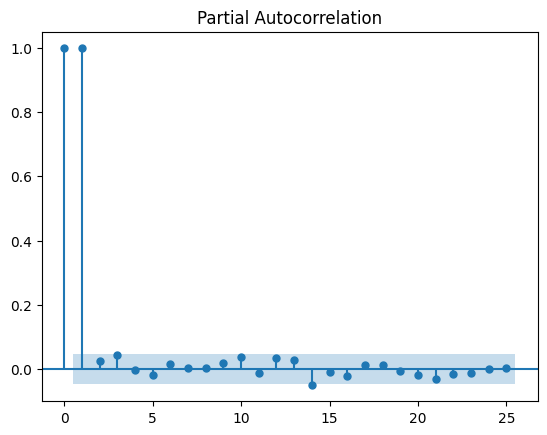

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(4, 2))
plot_pacf(df['Close'],lags=25)
plt.ylim(-0.1, 1.05)

In [ ]:
# Menentukan Timestep yang Akan Dipakai
n_lookback = 2

## Data Splitting

In [ ]:
# Calculate sizes
training_size = int(len(df) * 0.80)
val_size = int(len(df) * 0.10)
test_size = len(df) - training_size - val_size

# Convert sizes to integers
training_size = int(training_size)
val_size = int(val_size)
test_size = int(test_size)

# Split the data
data_train = df.iloc[:training_size]
data_validation = df.iloc[training_size:training_size + val_size]
data_test = df.iloc[training_size + val_size:]

# Print the shapes of the datasets
print("train_data: ", data_train.shape)
print("test_data: ", data_test.shape)
print("validation_data: ",data_validation.shape)

train_data:  (1388, 2)
test_data:  (174, 2)
validation_data:  (173, 2)


In [ ]:
# Print proporsi data untuk verifikasi
print(len(data_train) / len(df))
print(len(data_validation) / len(df))
print(len(data_test) / len(df))

0.8
0.09971181556195965
0.10028818443804034


In [ ]:
# Melihat Data Training/Pelatihan
data_train

,Date,Close
0,2017-06-22,9760.0
1,2017-06-23,9760.0
2,2017-06-26,9760.0
3,2017-06-27,9760.0
4,2017-06-28,9760.0
...,...,...
1383,2022-12-21,4780.0
1384,2022-12-22,4840.0
1385,2022-12-23,4820.0
1386,2022-12-26,4750.0


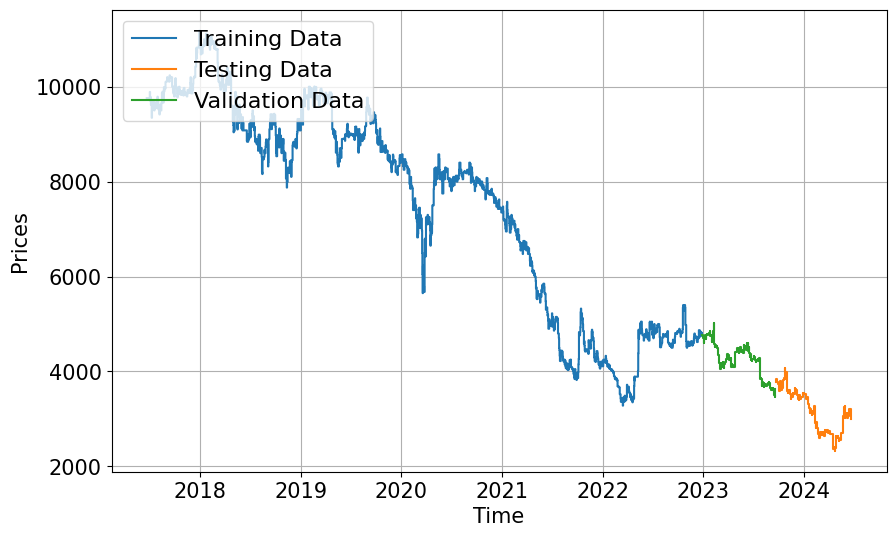

In [ ]:
# Plot Pembagian Data Training dan Data Testing
plt.subplots(figsize = (10,6))
ax=sns.lineplot(x="Date", y="Close",
             data=data_train, drawstyle='steps-post', label='Training Data')
ax=sns.lineplot(x="Date", y="Close",
             data=data_test, drawstyle='steps-post', label='Testing Data')
ax=sns.lineplot(x="Date", y="Close",
             data=data_validation, drawstyle='steps-post', label='Validation Data')
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Time', fontsize=15); plt.ylabel('Prices', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.grid()

In [ ]:
# Mengubah Dimensi Dataset
Close = df["Close"].values.reshape(-1, 1)

Close_train = data_train["Close"].values.reshape(-1, 1)

Close_test = data_test["Close"].values.reshape(-1, 1)

Close_val = data_validation.values.reshape(-1, 1)

print(Close_train.shape);print(Close_test.shape);print(Close_val.shape)

(1388, 1)
(174, 1)
(346, 1)


In [ ]:
# Melihat Data Pelatihan yang Sudah Diubah Dimensinya
Close_train[:5]

array([[9760.],
       [9760.],
       [9760.],
       [9760.],
       [9760.]])

In [ ]:
# Membuat Variabel Baru x_train dan y_train
x_train = []
y_train = []

for i in range(n_lookback, len(Close_train)):
    x_train.append(Close_train[i - n_lookback: i])
    y_train.append(Close_train[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1386, 2, 1)
(1386, 1)


In [ ]:
# Membuat Variabel Baru x_test dan y_test
x_test = []
y_test = []

for i in range(n_lookback, len(Close_test)):
    x_test.append(Close_test[i - n_lookback: i])
    y_test.append(Close_test[i])

x_test = np.array(x_test)
y_test= np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(172, 2, 1)
(172, 1)


In [ ]:
# Membuat Variabel Baru x_val dan y_val
x_val = []
y_val = []

for i in range(n_lookback, len(Close_val)):
    x_val.append(Close_val[i - n_lookback: i])
    y_val.append(Close_val[i])

x_val = np.array(x_val)
y_val= np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(344, 2, 1)
(344, 1)


## Data Normalization

In [ ]:
import numpy as np
from statistics import mean as Average, stdev

# Menggabungkan data training, validation, dan testing untuk menghitung mean dan std dev
Close = np.concatenate((data_train['Close'], data_validation['Close'], data_test['Close']))

# Hitung mean dan std dev dari data Close
mean_close = Average(Close)
std_dev_close = stdev(Close)

# Normalisasi seluruh data (training, validation, testing)
Close_scaled = normalize_series(Close, mean_close, std_dev_close)

# Normalisasi data training
data_train['Close_scaled'] = normalize_series(data_train['Close'], mean_close, std_dev_close)

# Normalisasi data validation
data_validation['Close_scaled'] = normalize_series(data_validation['Close'], mean_close, std_dev_close)

# Normalisasi data testing
data_test['Close_scaled'] = normalize_series(data_test['Close'], mean_close, std_dev_close)

Close_train_scaled = data_train['Close_scaled'].values.reshape(-1, 1)
Close_test_scaled = data_test['Close_scaled'].values.reshape(-1, 1)
Close_val_scaled = data_validation['Close_scaled'].values.reshape(-1, 1)

# Verifikasi hasil scaling
print(data_train.head())
print(data_validation.head())
print(data_test.head())

        Date   Close  Close_scaled
0 2017-06-22  9760.0      1.185921
1 2017-06-23  9760.0      1.185921
2 2017-06-26  9760.0      1.185921
3 2017-06-27  9760.0      1.185921
4 2017-06-28  9760.0      1.185921
           Date   Close  Close_scaled
1388 2022-12-28  4770.0     -0.806265
1389 2022-12-29  4760.0     -0.810257
1390 2022-12-30  4700.0     -0.834212
1391 2023-01-02  4620.0     -0.866150
1392 2023-01-03  4600.0     -0.874135
           Date   Close  Close_scaled
1561 2023-09-21  3770.0     -1.205501
1562 2023-09-22  3850.0     -1.173562
1563 2023-09-25  3820.0     -1.185539
1564 2023-09-26  3820.0     -1.185539
1565 2023-09-27  3770.0     -1.205501


<ipython-input-26-6408b9cac104>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Close_scaled'] = normalize_series(data_train['Close'], mean_close, std_dev_close)
<ipython-input-26-6408b9cac104>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_validation['Close_scaled'] = normalize_series(data_validation['Close'], mean_close, std_dev_close)
<ipython-input-26-6408b9cac104>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [ ]:
# Data Sebelum Dilakukan Scalling
Close[0:5]

array([9760., 9760., 9760., 9760., 9760.])

In [ ]:
# Data Sesudah Dilakukan Scalling
Close_scaled[0:5]

array([1.1859209, 1.1859209, 1.1859209, 1.1859209, 1.1859209])

In [ ]:
# Membuat Feature dan label Untuk Data Pelatihan Dari Data yang Sudah Discalling
x_train_scaled = []
y_train_scaled = []

for i in range(n_lookback, len(Close_train_scaled)):
    x_train_scaled.append(Close_train_scaled[i - n_lookback: i])
    y_train_scaled.append(Close_train_scaled[i])

x_train_scaled = np.array(x_train_scaled)
y_train_scaled = np.array(y_train_scaled)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(1386, 2, 1)
(1386, 1)


In [ ]:
# Melihat Dimensi Dari Data Pertama
print(x_train[0].shape)

(2, 1)


In [ ]:
# Membuat Feature dan label Untuk Data Pengujian Dari Data yang Sudah Di scalling
x_test_scaled = []
y_test_scaled = []

for i in range(n_lookback, len(Close_test_scaled)):
    x_test_scaled.append(Close_test_scaled[i - n_lookback: i])
    y_test_scaled.append(Close_test_scaled[i])

x_test_scaled = np.array(x_test_scaled)
y_test_scaled = np.array(y_test_scaled)
print(x_test_scaled.shape)
print(y_test_scaled.shape)

(172, 2, 1)
(172, 1)


In [ ]:
# Membuat Feature dan label Untuk Data Pengujian Dari Data yang Sudah Di scalling
x_val_scaled = []
y_val_scaled = []

for i in range(n_lookback, len(Close_val_scaled)):
    x_val_scaled.append(Close_val_scaled[i - n_lookback: i])
    y_val_scaled.append(Close_val_scaled[i])

x_val_scaled = np.array(x_val_scaled)
y_val_scaled = np.array(y_val_scaled)
print(x_val_scaled.shape)
print(y_val_scaled.shape)

(171, 2, 1)
(171, 1)


# Model Architecture

In [ ]:
# Membuat Arsitektur Model yang Akan Digunakan

# Model LSTM
model = Sequential()
model.add(LSTM(16, return_sequences=False, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.5), input_shape=(n_lookback,1)))
model.add(Dense(1))
model.compile(loss='huber', optimizer=Adam(learning_rate=0.0005)) #ubah ini <1

## Model Training

In [ ]:
# Menentukan File Tujuan Untuk Menyimpan Bobot Model
filepath = "best_model.h5"

# Membuat ModelCheckpoint Callback Untuk Menyimpan Bobot Model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min')

# Membuat Konfigurasi EarlyStopping Callback yang Berfungsi Untuk Memberhentikan Proses Training Ketika Nilai Loss Berhenti Membaik
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Fit the model to the data
history = model.fit(x_train_scaled, y_train_scaled, epochs=100, validation_data=(x_val_scaled, y_val_scaled) ,batch_size=16,verbose=1, callbacks=[checkpoint])

Epoch 1/100
87/87 [==============================] - 2s 7ms/step - loss: 1.3222 - val_loss: 1.2957
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.9448 - val_loss: 1.0077
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.6928 - val_loss: 0.8286
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5226 - val_loss: 0.7296
Epoch 5/100
87/87 [==============================] - 0s 3ms/step - loss: 0.4051 - val_loss: 0.6369
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.3147 - val_loss: 0.5175
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.2389 - val_loss: 0.3730
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.1759 - val_loss: 0.2350
Epoch 9/100
87/87 [==============================] - 0s 3ms/step - loss: 0.1288 - val_loss: 0.1532
Epoch 10/100
87/87 [==============================] - 0s 3ms/step - loss: 0.0974 - val_loss: 0.1059
Epoch 11/

## Training and Validation

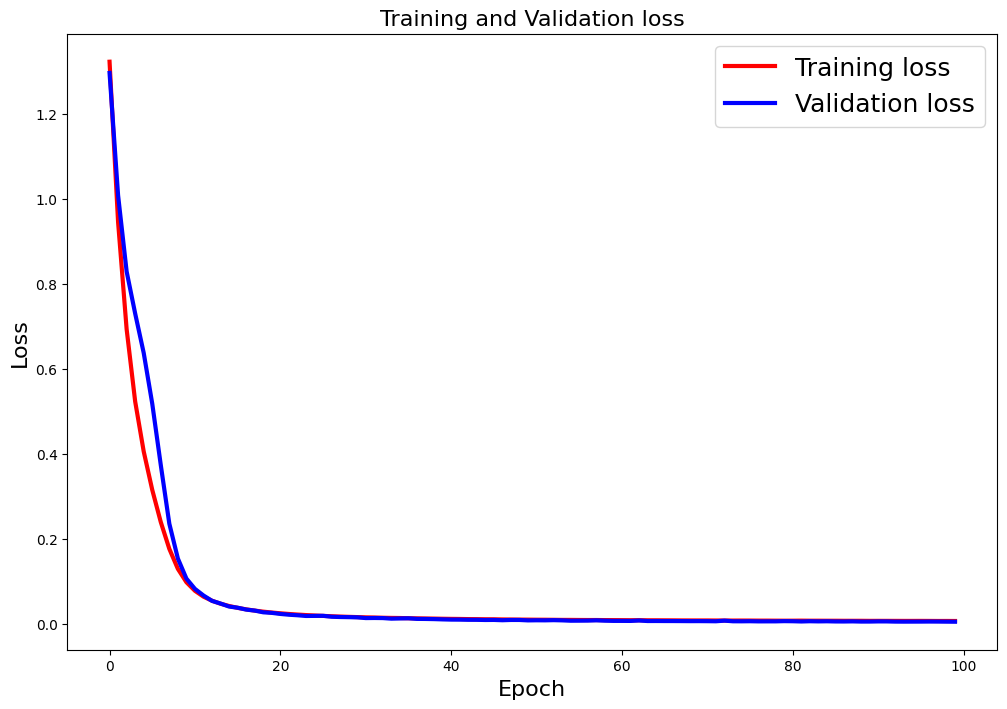

In [ ]:
plt.figure(figsize=[12,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training and Validation loss',fontsize=16)
#plt.xlim(0, 10)  # Mengatur batas sumbu y dari 0 hingga 0.2
plt.show()


In [ ]:
forecast_train_data = model_forecast(model,Close_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(Close_train_scaled.shape[0]-n_lookback)

1387/1387 [==============================] - 3s 2ms/step
(1387, 1)
(1386,)
1386


# Evaluation

## Training Evaluation

### Denormalization

In [ ]:
# Pastikan Anda mengambil kolom Close dari data_train
Close_train_values = data_train['Close'].values

# Hitung rata-rata dan standar deviasi dari Close_train_values
mean_close_train = np.mean(Close_train_values)
std_dev_close_train = np.std(Close_train_values)

# Denormalisasi forecast_train_data
forecast_train_data = inverse_normalize_series(forecast_train_data, mean_close_train, std_dev_close_train)
forecast_train_data[:5]

array([10096.818, 10096.818, 10096.818, 10096.818, 10096.818],
      dtype=float32)

In [ ]:
actual = np.squeeze(Close_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1386,)
[9760. 9760. 9760. 9760. 9760.]


### Actual Data vs. Predicted Data

```
# This is formatted as code
```



In [ ]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train['Date'][-forecast_train_data.shape[0]:]
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

,Date,Actual,Forecast
2,2017-06-26,9760.0,10096.818359
3,2017-06-27,9760.0,10096.818359
4,2017-06-28,9760.0,10096.818359
5,2017-06-29,9760.0,10096.818359
6,2017-06-30,9760.0,10096.818359
...,...,...,...
1383,2022-12-21,4780.0,5735.292969
1384,2022-12-22,4840.0,5765.213867
1385,2022-12-23,4820.0,5781.983887
1386,2022-12-26,4750.0,5821.208008


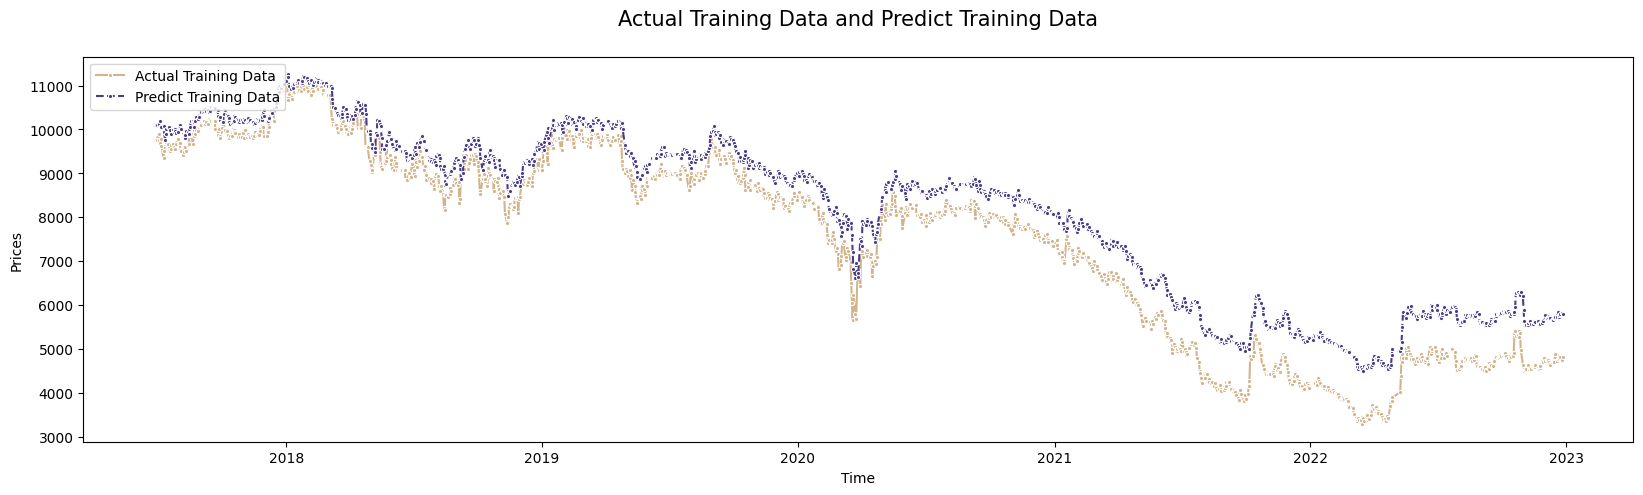

In [ ]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train,
                    label="Actual Training Data", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train,
                    label="Predict Training Data", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Time'); plt.ylabel('Prices')
plt.title("Actual Training Data and Predict Training Data\n", fontsize = 15)
plt.legend(loc='upper left')

In [ ]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Train Accuracy
RMSE:  713.1211
MAE:  634.2921
MAPE:  0.092472


## Validation-Evaluation

### Denormalization

In [ ]:
forecast_val_data = model_forecast(model,Close_val_scaled, n_lookback, 1)

# Pastikan Anda mengambil kolom Close dari data_train
Close_val_values = data_validation['Close'].values

# Hitung rata-rata dan standar deviasi dari Close_train_values
mean_close_val = np.mean(Close_val_values)
std_dev_close_val = np.std(Close_val_values)

# Denormalisasi forecast_train_data
forecast_val_data = inverse_normalize_series(forecast_val_data, mean_close_val, std_dev_close_val)
print(forecast_val_data.shape)
print(Close_val_scaled.shape[0]-n_lookback)

172/172 [==============================] - 0s 2ms/step
(172, 1)
171


### Actual Data vs. Predicted Data

In [ ]:
actual = np.squeeze(Close_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1386,)
[9760. 9760. 9760. 9760. 9760.]


In [ ]:
len(data_validation[-forecast_val_data.shape[0]:])

172

In [ ]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_validation['Date'][-forecast_val_data.shape[0]:]
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = data_validation['Close']
df_val

,Date,Actual,Forecast
1389,2022-12-29,4760.0,3958.318848
1390,2022-12-30,4700.0,3955.490479
1391,2023-01-02,4620.0,3946.149658
1392,2023-01-03,4600.0,3936.056396
1393,2023-01-04,4640.0,3934.759521
...,...,...,...
1556,2023-09-14,3560.0,3784.771484
1557,2023-09-15,3500.0,3779.554688
1558,2023-09-18,3470.0,3771.575195
1559,2023-09-19,3580.0,3770.993652


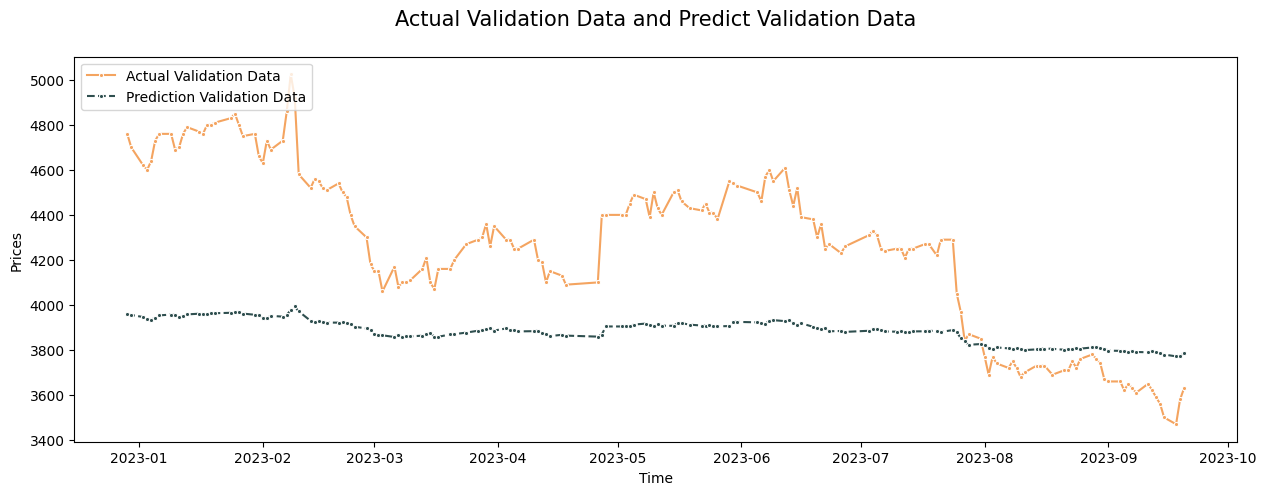

In [ ]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val,
                    label="Actual Validation Data", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val,
                    label="Prediction Validation Data", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Time'); plt.ylabel('Prices')
plt.title("Actual Validation Data and Predict Validation Data\n", fontsize = 15)
plt.legend(loc='upper left')

# Summary for Training and Validation

In [ ]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Train Accuracy
RMSE:  713.1211
MAE:  634.2921
MAPE:  0.092472
Forecast Val Accuracy
RMSE:  488.7797
MAE:  423.9033
MAPE:  0.108348


# Forecasting

In [ ]:
# Meramalkan Untuk 15 Periode Ke Depan
forecast_values = multi_step_forecasts(n_lookback=n_lookback, n_forecast=15, model=model, data=Close, data_scaled=Close_scaled)

1/1 [==============================] - 0s 46ms/step


In [ ]:
# Rentang Tanggal Yang Akan Diramal
date_forecast = [dt.strftime('%Y-%m-%d') for dt in
       datetime_range(datetime(2024,6,22), datetime(2024,7,7),
       relativedelta(days=1))]

print(np.shape(date_forecast))

(15,)


In [ ]:
# Hasil Peramalan
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = date_forecast
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = np.squeeze(forecast_values)
df_forecast

,Date,Forecast
0,2024-06-22,3008.685303
1,2024-06-23,2971.650635
2,2024-06-24,2979.929932
3,2024-06-25,2951.467773
4,2024-06-26,2952.908691
5,2024-06-27,2930.125732
6,2024-06-28,2927.077148
7,2024-06-29,2908.062744
8,2024-06-30,2902.076904
9,2024-07-01,2885.569336


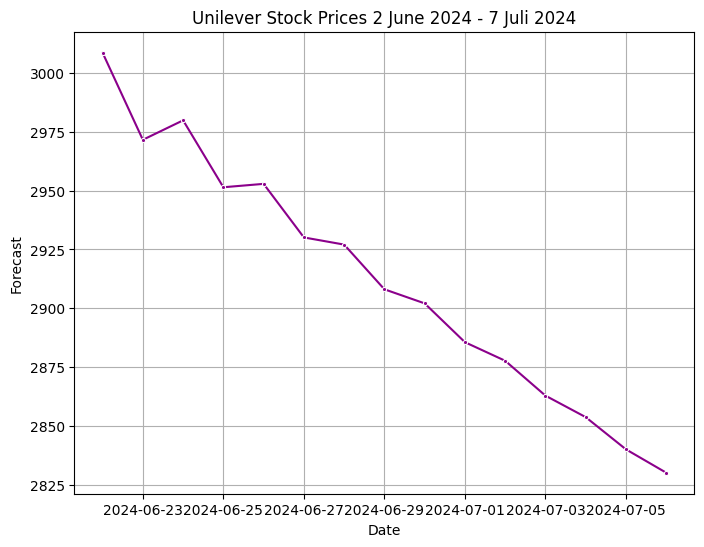

In [ ]:
# Plot Hasil Peramalan
from turtle import color

plt.subplots(figsize = (8,6))
sns.lineplot(x="Date", y="Forecast",
             data=df_forecast, marker='.', color = 'darkmagenta')
plt.title("Unilever Stock Prices 2 June 2024 - 7 Juli 2024")
plt.grid()

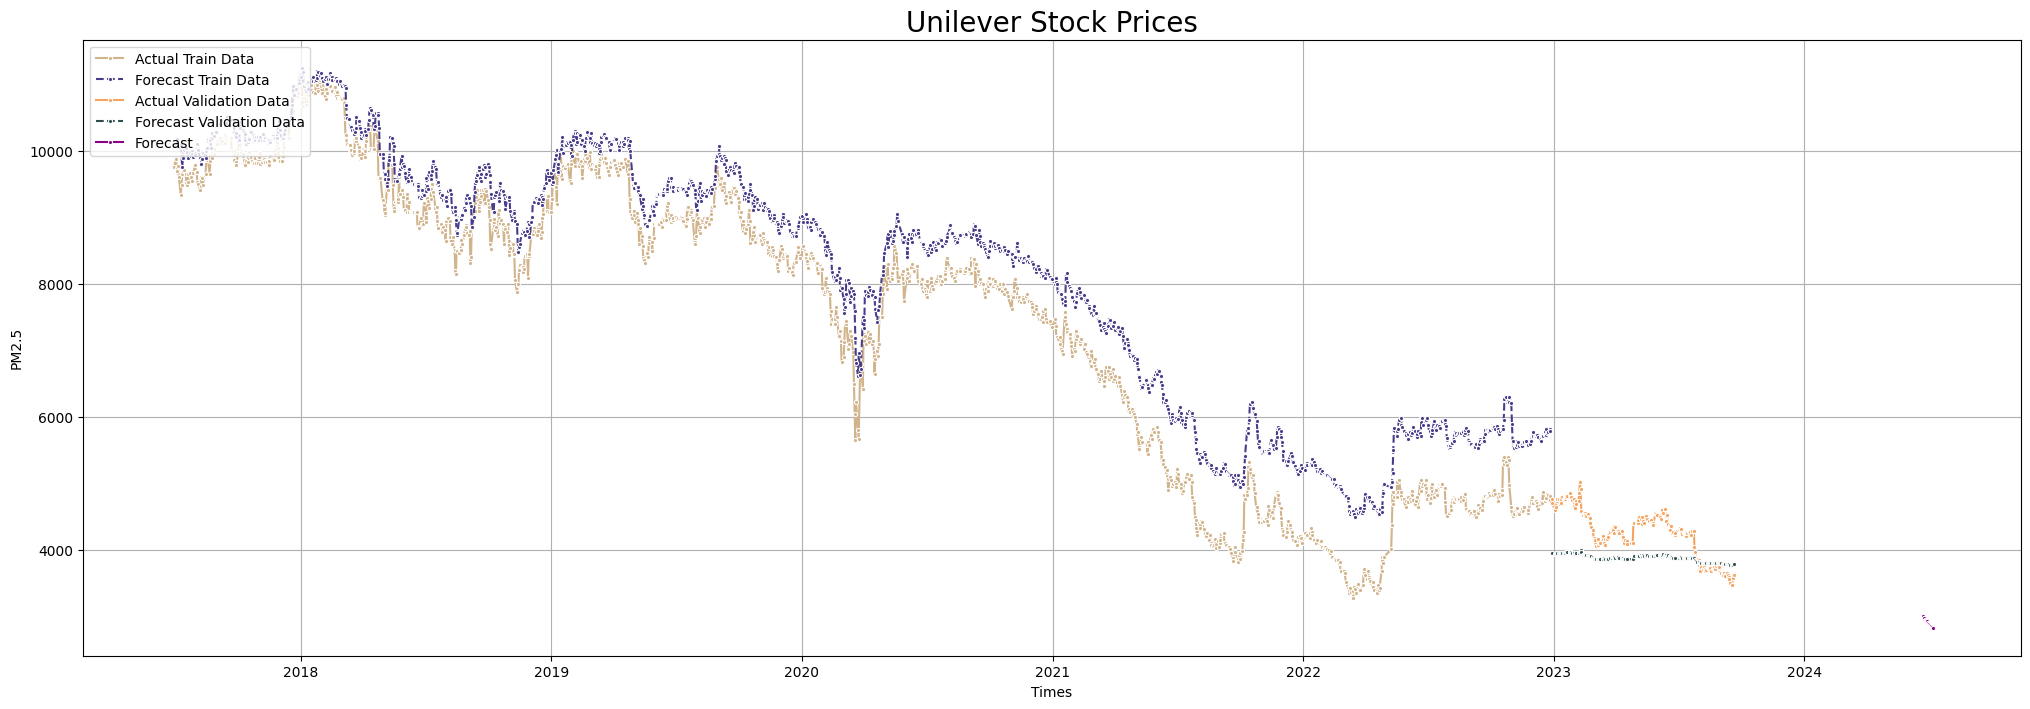

In [ ]:
# Plot Data Aktual dan Hasil Peramalan
fig, ax = plt.subplots(figsize = (25,8))
ax = sns.lineplot(x="Date", y="Actual", data=df_train,
                    label="Actual Train Data", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train,
                    label="Forecast Train Data", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val,
                    label="Actual Validation Data", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val,
                    label="Forecast Validation Data", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast,
                    label="Forecast", marker='.', color = 'darkmagenta')
plt.grid()
plt.xlabel('Times'); plt.ylabel('PM2.5')
plt.title("Unilever Stock Prices", fontsize = 20)
plt.legend(loc='upper left')

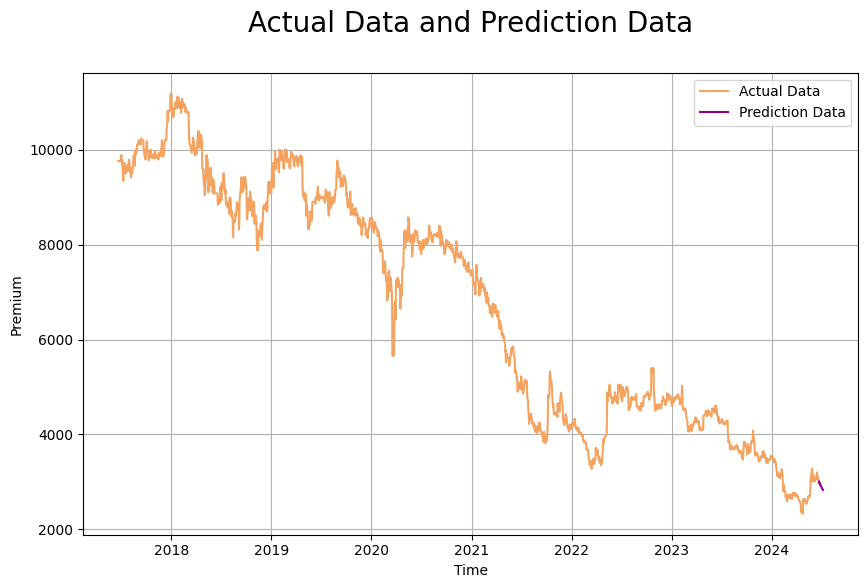

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(x="Date", y="Close", data=df,
                    label="Actual Data", color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast,
                    label="Prediction Data", color='darkmagenta')
plt.title("Actual Data and Prediction Data\n", fontsize = 20)
plt.xlabel('Time'); plt.ylabel('Premium')
plt.grid()